## Preparing Data

In [1527]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import pandas as pd 
import torch
import torchtext
from torchtext import data
import spacy
import os
import re

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import pandas as pd

spacy_en = spacy.load('en')

_stopwords = spacy.lang.en.stop_words.STOP_WORDS

os.environ['OMP_NUM_THREADS'] = '4'


SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#FILTER_SIZES = [2,3,4]
def tokenizer(text):
    token = [t.text for t in spacy_en.tokenizer(text)]
#    if len(token) < FILTER_SIZES[-1]:
    for i in range(1, 7):
        token.append('<PAD>')
    return token


TEXT = data.Field(lower=True,include_lengths=False,tokenize=tokenizer, stop_words = _stopwords)

LABEL = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                            unk_token=None, dtype = torch.float)

dataFields = {"comment_text": ("comment_text", TEXT), 
              'label_int': ("hate_speech", LABEL)}



In [1528]:
data_dir = './data/sampled_train/'
data_name = 'train.json'

In [1529]:
dataset= data.TabularDataset(path=data_dir+data_name, 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=True)

In [1530]:
import random
SEED = 3 
train_data, test_val_data = dataset.split(split_ratio=0.8,random_state = random.seed(SEED))

val_data, test_data = dataset.split(split_ratio=0.5,random_state = random.seed(SEED))

In [1531]:
MAX_VOCAB_SIZE = 20_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

In [1532]:
yFields = ['hate_speech']

In [1533]:
#import pickle

#pickle.dump(TEXT, open('./custom_embeddings/train_data_field', 'wb'))

In [1534]:
TEXT.vocab

In [1535]:
BATCH_SIZE = 64


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.comment_text),
    sort_within_batch = True,
    device = device)



In [1536]:
for i in train_iterator:
    aux = i
    break

## Build model

In [1537]:
aux.comment_text[0]

tensor([ 293,  579,  223, 3829,   76,   16, 4658,  518,  235,  293,  521,  330,
         229, 1166, 1852,  519,   66,   17,  156,  391,   34, 1969,  715,   63,
         327, 2075,  324,  240, 1181,  594,    8,    3,   18,  124,   46, 1726,
          55,  935,  265,  146,  120, 2923,  801,   65, 2581,   75, 2378,  159,
        1059,  560,   90,   79, 2912,  253,  454,  771,   15, 5069,   75,   46,
        3832, 1352,  443,  339])

In [1538]:


import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)




In [1557]:
INPUT_DIM = len(TEXT.vocab) # 20002
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4,5,6]
OUTPUT_DIM = 1
DROPOUT = 0.8
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # 1

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES ,OUTPUT_DIM, DROPOUT, PAD_IDX)

In [1558]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 756,701 trainable parameters


In [1559]:
for i in train_iterator:
    aux=i
    break

from torchsummaryX import summary
print(aux.comment_text.size())
summary(model, aux.comment_text )

torch.Size([20, 64])
                      Kernel Shape      Output Shape  Params Mult-Adds
Layer                                                                 
0_embedding            [100, 5557]     [64, 20, 100]  555.7k    555.7k
1_convs.Conv2d_0  [1, 100, 2, 100]  [64, 100, 19, 1]   20.1k    380.0k
2_convs.Conv2d_1  [1, 100, 3, 100]  [64, 100, 18, 1]   30.1k    540.0k
3_convs.Conv2d_2  [1, 100, 4, 100]  [64, 100, 17, 1]   40.1k    680.0k
4_convs.Conv2d_3  [1, 100, 5, 100]  [64, 100, 16, 1]   50.1k    800.0k
5_convs.Conv2d_4  [1, 100, 6, 100]  [64, 100, 15, 1]   60.1k    900.0k
6_dropout                        -         [64, 500]       -         -
7_fc                      [500, 1]           [64, 1]   501.0     500.0
-------------------------------------------------------------------------
                        Totals
Total params          756.701k
Trainable params      756.701k
Non-trainable params       0.0
Mult-Adds              3.8562M


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_embedding,"[100, 5557]","[64, 20, 100]",555700.0,555700.0
1_convs.Conv2d_0,"[1, 100, 2, 100]","[64, 100, 19, 1]",20100.0,380000.0
2_convs.Conv2d_1,"[1, 100, 3, 100]","[64, 100, 18, 1]",30100.0,540000.0
3_convs.Conv2d_2,"[1, 100, 4, 100]","[64, 100, 17, 1]",40100.0,680000.0
4_convs.Conv2d_3,"[1, 100, 5, 100]","[64, 100, 16, 1]",50100.0,800000.0
5_convs.Conv2d_4,"[1, 100, 6, 100]","[64, 100, 15, 1]",60100.0,900000.0
6_dropout,-,"[64, 500]",NaN,NaN
7_fc,"[500, 1]","[64, 1]",501.0,500.0


In [1560]:
model.embedding.weight.data.copy_(TEXT.vocab.vectors)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-1.0889,  0.1550,  0.3195,  ..., -0.5389, -0.0420, -0.2176],
        ...,
        [-1.2307, -1.2536, -0.7483,  ..., -0.1161,  1.8930,  0.1692],
        [-1.1252,  1.4676, -0.5903,  ..., -0.5557,  0.6070,  0.4536],
        [ 0.9452,  0.8951, -0.3782,  ...,  0.4434, -0.8536, -0.1599]])

In [1561]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.requires_grad = True

## Train our model

In [1562]:

def print_metrics(pred, labels, thre= 0.5):
    toxic_labels = ['hate_speech']
    
    roc_auc_scores= []
    recall_scores=[]
    precision_scores=[]
    accuracy_scores=[]
    f1_scores=[]

     
    for i,j in enumerate(toxic_labels):
        roc_auc_scores.append(roc_auc_score(labels[:,i], pred[:,i]))
        recall_scores.append(recall_score(labels[:,i], pred[:,i]>=thre))
        accuracy_scores.append(accuracy_score(labels[:,i], pred[:,i]>=thre))
        precision_scores.append(precision_score(labels[:,i], pred[:,i]>=thre))
        f1_scores.append(f1_score(labels[:,i], pred[:,i]>=thre))
    return pd.DataFrame(
    {'Label': toxic_labels,
     'accuracy': accuracy_scores,
     'recall': recall_scores,
     'precision': precision_scores,
     'f1': f1_scores,
     'roc_auc': roc_auc_scores})

In [1563]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [1564]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [1565]:
import numpy
from sklearn.metrics import roc_auc_score


In [1566]:


def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    preds_list=[]
    labels_list= []
    epoch_loss_hist = []

    
    j = len(iterator)//10
    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        
        text = batch.comment_text
        
        predictions = model(text)
        
        batch_labels=torch.stack([getattr(batch, y) for y in yFields]) #transpose?
        batch_labels = torch.transpose(batch_labels,0,1)
        
        loss = criterion(predictions, batch_labels)
        
        loss.backward()
        
        optimizer.step()
        
        preds_list+=[torch.sigmoid(predictions).detach().numpy()]
        labels_list+=[batch_labels.numpy()]
        

                    
        epoch_loss += loss.item()
        
        if i%j ==0:
            epoch_loss_hist.append([loss.item(),
            evaluate(model, valid_iterator, criterion)[0]])
            model.train()
        
    return (epoch_loss / len(iterator) , epoch_loss_hist, 
           roc_auc_score(np.vstack(labels_list), np.vstack(preds_list)))

In [1567]:


def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    preds_list=[]
    labels_list= []
    epoch_acc=[]


    
    with torch.no_grad():
        i=0
        for batch in iterator:
            i+=1
            text = batch.comment_text
            
            predictions = model(text)#.squeeze(1)
            
            batch_labels = torch.stack([getattr(batch, y) for y in yFields]) #transpose?
            batch_labels = torch.transpose(batch_labels,0,1)
            
            loss = criterion(predictions, batch_labels)

            epoch_loss += loss.item()

            
            preds_list+=[torch.sigmoid(predictions).detach().numpy()]
            labels_list+=[batch_labels.numpy()]
            
        
    return (epoch_loss / len(iterator),
           roc_auc_score(np.vstack(labels_list), np.vstack(preds_list)) ,
           np.vstack(preds_list), np.vstack(labels_list))



In [1568]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [1569]:
model.embedding.weight.requires_grad = False

N_EPOCHS = 4
best_valid_loss = float('inf')
loss_hist= []
UNFREEZE = 2
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, _loss_hist, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc , _preds  , _labels  = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    
    loss_hist+= _loss_hist
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ws-model.pt')
        

    if (epoch) > UNFREEZE:
        #unfreeze embeddings
        model.embedding.weight.requires_grad = True 
    
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    


Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.680 | Train Acc: 63.10%
	 Val. Loss: 0.570 |  Val. Acc: 85.72%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.565 | Train Acc: 79.39%
	 Val. Loss: 0.495 |  Val. Acc: 87.89%
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.502 | Train Acc: 84.75%
	 Val. Loss: 0.442 |  Val. Acc: 90.24%
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.466 | Train Acc: 86.54%
	 Val. Loss: 0.404 |  Val. Acc: 91.92%


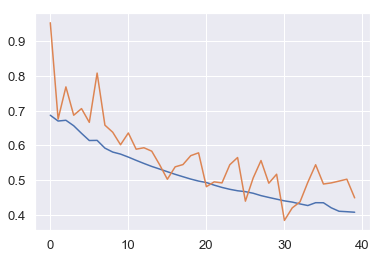

In [1570]:
plt.plot([i[1] for i in loss_hist])
plt.plot([i[0] for i in loss_hist])

In [1571]:
print_metrics(_preds , _labels,0.5)

,Label,accuracy,recall,precision,f1,roc_auc
0,hate_speech,0.842809,0.826235,0.849387,0.837651,0.919184


In [1573]:
print_metrics(_preds , _labels,0.45)

,Label,accuracy,recall,precision,f1,roc_auc
0,hate_speech,0.840301,0.865417,0.819355,0.841756,0.919184


In [1576]:
for epoch in range(1):

    start_time = time.time()
    
    valid_loss, valid_acc , _preds  , _labels  = evaluate(model, test_iterator, criterion)
    end_time = time.time()
    

    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'\t test. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	 test. Loss: 0.448 |  Val. Acc: 88.82%


## Application to Jigswa/Googgle Toxicity

In [1577]:
dataFields_toxic = {"comment_text": ("comment_text", TEXT), 
              'toxic': ("toxic", LABEL), 
              'severe_toxic': ("severe_toxic", LABEL),
              'threat': ("threat", LABEL), 
              'obscene': ("obscene", LABEL),
              'insult': ("insult", LABEL), 
              'identity_hate': ("identity_hate", LABEL)}

In [1578]:
toxic_dir = '../deep-toxic-analysis/sorting/data/'
toxicset= data.TabularDataset(path=toxic_dir+'train.json', 
                                            format='json',
                                            fields=dataFields_toxic, 
                                            skip_header=False)

In [1579]:
toxic_iterator = torchtext.data.Iterator(toxicset, batch_size=256, device=device, 
                                     sort=False, sort_within_batch=False, 
                                     repeat=False,shuffle=False)

In [1580]:
toxic_preds=[]
with torch.no_grad():
    model.eval()
    for batch in toxic_iterator:

        torch.cuda.empty_cache()
    
        text = batch.comment_text  
        predictions = model(text)        
        toxic_preds+=[torch.sigmoid(predictions).detach().numpy()]
    
        torch.cuda.empty_cache()
toxic_preds = np.vstack(toxic_preds)

In [1583]:
df_toxic= pd.read_csv(toxic_dir+'train.csv')
df_toxic['hate_speech'] = toxic_preds

In [1584]:
print_metrics(np.array([[i] for i in df_toxic['hate_speech'] ]) , 
              np.array([[i] for i in df_toxic['identity_hate'] ]), 0.45) 

,Label,accuracy,recall,precision,f1,roc_auc
0,hate_speech,0.889341,0.704626,0.054297,0.100825,0.881757


In [ ]:
print_metrics(_preds , _labels,0.45)

## Application to Liar-Liar-pants on fire

In [1364]:
dataFields = {"statement": ("statement", TEXT)}

testDataset= data.TabularDataset(path='../deep-toxic-analysis/deep-fake-toxicity/data/liar_dataset/liar.json', 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=False)

In [1365]:
len(testDataset)

10240

In [1366]:
test_iterator = torchtext.data.Iterator(testDataset, batch_size=64, device=device, 
                                     sort=False, sort_within_batch=False, 
                                     repeat=False,shuffle=False)

myPreds=[]
with torch.no_grad():
    model.eval()
    for batch in test_iterator:

        torch.cuda.empty_cache()
    
        text = batch.statement    
        predictions = model(text)        
        myPreds+=[torch.sigmoid(predictions).detach().numpy()]
    
        torch.cuda.empty_cache()
myPreds = np.vstack(myPreds)

In [1367]:
len(myPreds)

10240

In [1368]:
myPreds.sum()

3626.9841

In [1369]:

df = pd.read_csv("../deep-toxic-analysis/deep-fake-toxicity/data/liar_dataset/train.csv")
df['hate_speech'] = myPreds[:, 0]#np.round().astype(np.int)

/Users/rene/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Probabilities of hate_speechvs Fake News labels')

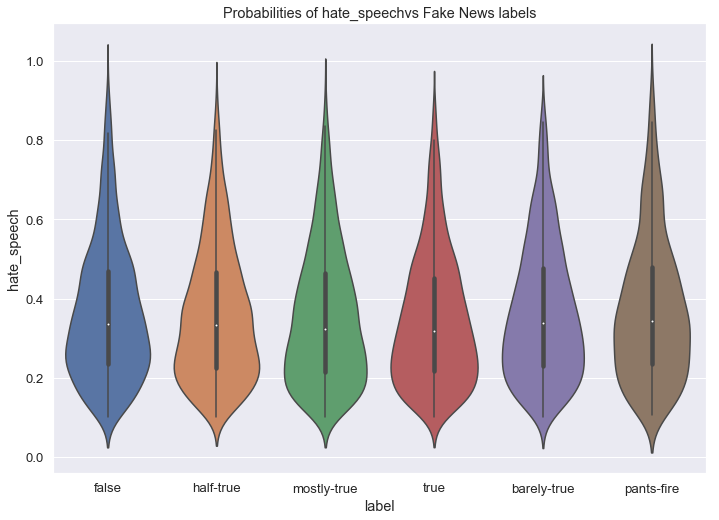

In [1370]:
from matplotlib import pyplot
import seaborn as sns

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
th=0.1
cat= 'hate_speech'
_df = df[ (df[cat]>th)  ] 
sns.violinplot(ax= ax, y=cat,x= 'label' , data= _df, kind="box", sizes=(20, 20))
sns.set(font_scale=1.2)
plt.title('Probabilities of ' + cat + 'vs Fake News labels')

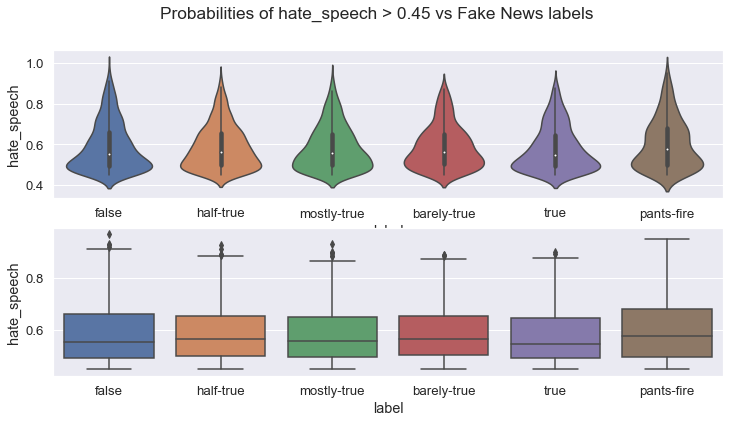

In [1371]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(12, 6))
axx=ax.flat
th=0.45
cat= 'hate_speech'
_df = df[ (df[cat]>=th)  ] 

sns.violinplot(y=cat,x= 'label' , data= _df, kind="box", ax=axx[0])
sns.catplot(y=cat,x= 'label' , data=_df, kind="box", ax=axx[1])
sns.set(font_scale=1.2)
fig.suptitle('Probabilities of '+cat+' > '+ str(th) +' vs Fake News labels')

plt.close(2);

In [1372]:
df['label'].value_counts(normalize=True)

half-true      0.206445
false          0.194824
mostly-true    0.191602
true           0.163672
barely-true    0.161523
pants-fire     0.081934
Name: label, dtype: float64

In [1373]:
_label= 'hate_speech'
_df= df[['statement',_label, 'label']].sort_values(by=_label, ascending=True).head(1000)

In [1374]:
def fox(col):
    if type(col)==str:
        return ('fox' in col.lower())
    else: return False

In [1375]:
df.sort_values('hate_speech', ascending = False)

,ID,label,statement,subject,speaker,speaker_job,state_info,afiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,hate_speech
5520,10266.json,false,The conviction rate is almost exactly the same...,"civil-rights,crime,criminal-justice",rudy-giuliani,Attorney,New York,republican,9.0,11.0,10.0,7.0,3.0,an interview on 'Fox and Friends',0.965716
742,13453.json,pants-fire,Says thousands at a Manhattan rally for Donald...,"diversity,islam",social-media,NaN,NaN,none,0.0,0.0,0.0,0.0,2.0,a viral Tweet,0.949250
2518,9530.json,pants-fire,Obama regime planned the influx of illegal ali...,"children,immigration",rush-limbaugh,Radio host,NaN,none,9.0,11.0,5.0,2.0,10.0,"a broadcast of the ""Rush Limbaugh Show""",0.947889
3702,12649.json,mostly-true,"For 21 countries in Sub-Saharan Africa, we sim...","economy,foreign-policy",morten-jerven,NaN,NaN,none,0.0,0.0,0.0,1.0,0.0,an article,0.930080
8247,5426.json,false,There are more atheists in the country right n...,religion,david-silverman,"President, American Atheists",NaN,activist,0.0,1.0,0.0,0.0,0.0,a story on TV website,0.927711
759,13039.json,false,"Our veterans, in many cases, are being treated...","immigration,veterans",donald-trump,President-Elect,New York,republican,63.0,114.0,51.0,37.0,61.0,a speech in Philadelphia,0.924800
5609,12422.json,half-true,Says North Carolina Rep. Renee Ellmers was the...,"congress,crime,criminal-justice,immigration,pu...",george-holding,U.S. Representative,North Carolina,republican,0.0,0.0,1.0,0.0,0.0,a debate on WRAL,0.923644
3374,10318.json,false,The wealth gap between blacks and whites in th...,"income,wealth",nicholas-kristof,NaN,NaN,none,0.0,1.0,0.0,2.0,0.0,"a broadcast of ""The Daily Show""",0.918573
261,2411.json,pants-fire,Ron Klein repeatedly voted in favor of amnesty...,immigration,allen-west,"U.S. representative, Florida District 22",Florida,republican,6.0,9.0,3.0,1.0,4.0,a campaign website,0.913198
2434,12659.json,half-true,Says Hillary Clinton has been given tens of mi...,campaign-finance,donald-trump,President-Elect,New York,republican,63.0,114.0,51.0,37.0,61.0,a Phoenix rally,0.911658


In [1376]:
df.loc[742].statement

'Says thousands at a Manhattan rally for Donald Trump were chanting We hate Muslims, we hate blacks, we want our great country back.'

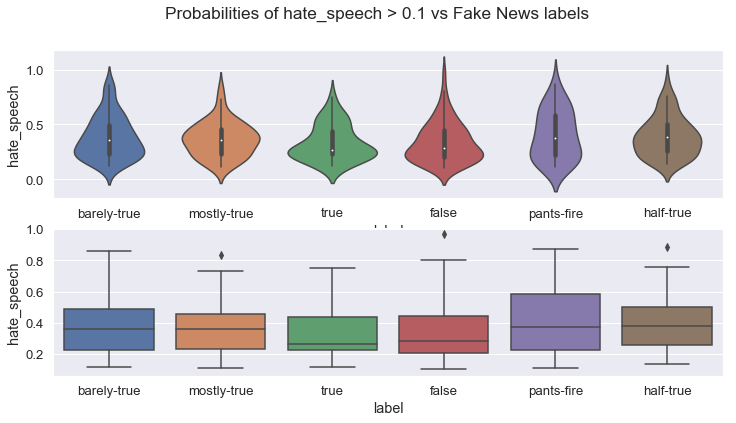

In [1377]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(12, 6))
axx=ax.flat
th=0.1
cat= 'hate_speech'
df1= df[df['context'].apply(fox)]
_df = df1[ (df1[cat]>=th)  ] 

sns.violinplot(y=cat,x= 'label' , data= _df, kind="box", ax=axx[0])
sns.catplot(y=cat,x= 'label' , data=_df, kind="box", ax=axx[1])
sns.set(font_scale=1.2)
fig.suptitle('Probabilities of '+cat+' > '+ str(th) +' vs Fake News labels')

plt.close(2);

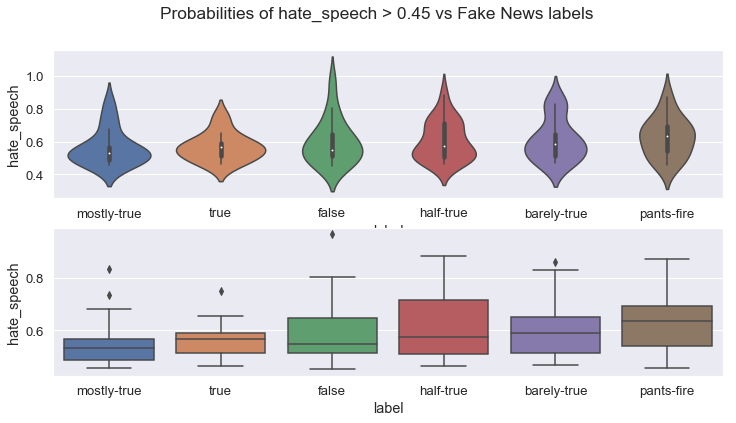

In [1378]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(12, 6))
axx=ax.flat
th=0.45
cat= 'hate_speech'
df1= df[df['context'].apply(fox)]
_df = df1[ (df1[cat]>=th)  ] 

sns.violinplot(y=cat,x= 'label' , data= _df, kind="box", ax=axx[0])
sns.catplot(y=cat,x= 'label' , data=_df, kind="box", ax=axx[1])
sns.set(font_scale=1.2)
fig.suptitle('Probabilities of '+cat+' > '+ str(th) +' vs Fake News labels')

plt.close(2);

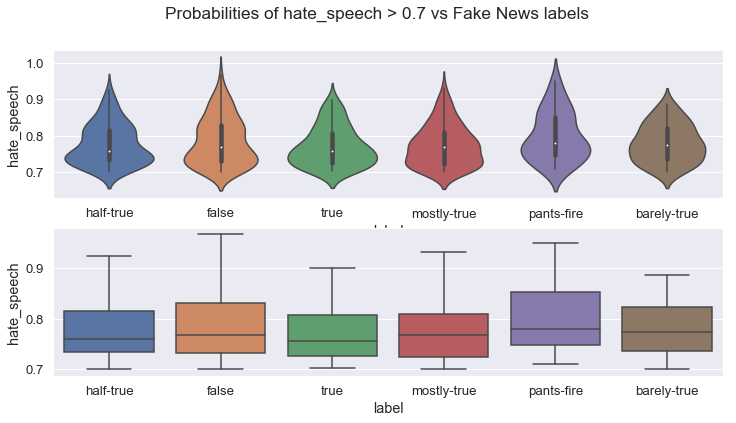

In [1379]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(12, 6))
axx=ax.flat
th=0.7
cat= 'hate_speech'
_df = df[ (df[cat]>=th)  ] 

sns.violinplot(y=cat,x= 'label' , data= _df, kind="box", ax=axx[0])
sns.catplot(y=cat,x= 'label' , data=_df, kind="box", ax=axx[1])
sns.set(font_scale=1.2)
fig.suptitle('Probabilities of '+cat+' > '+ str(th) +' vs Fake News labels')

plt.close(2);

In [1380]:
def group_lies(col):
    if col in ['pants-fire', 'false','half-true','mostly-true','barely-true']:
        return 'mostly-false'
    else: return 'true'
df['group_lies'] = df['label'].apply(group_lies);

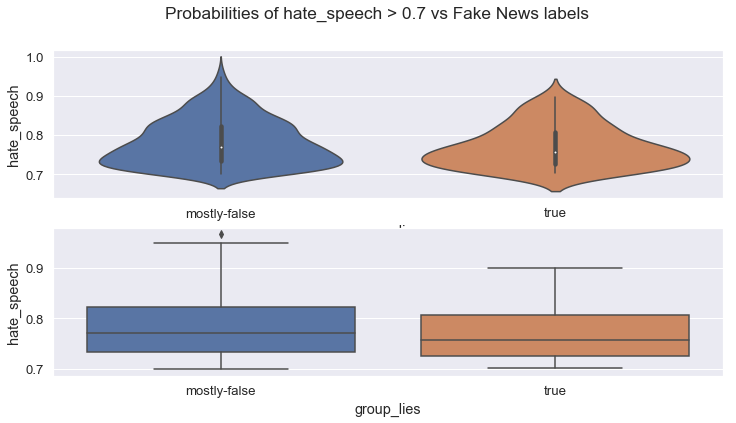

In [1381]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(12, 6))
axx=ax.flat
th=0.7
cat= 'hate_speech'

_df = df[ (df[cat]>=th)] 

sns.violinplot(y=cat,x= 'group_lies' , data= _df, kind="box", ax=axx[0])
sns.catplot(y=cat,x= 'group_lies' , data=_df, kind="box", ax=axx[1])
sns.set(font_scale=1.2)
fig.suptitle('Probabilities of '+cat+' > '+ str(th) +' vs Fake News labels')

plt.close(2);

In [1382]:
df[(df.label=='true' ) &  (df.hate_speech>=0.45)].describe()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,hate_speech
count,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000
mean,11.247596,11.093750,19.360577,19.314904,3.391827,0.578909
std,19.082162,19.700489,39.577647,40.324758,8.351197,0.108164
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.450123
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.492257
50%,2.000000,2.000000,3.000000,3.000000,0.000000,0.547565
75%,12.000000,9.000000,12.000000,12.000000,3.000000,0.646349
max,70.000000,114.000000,160.000000,163.000000,105.000000,0.898695


In [1383]:
df.sort_values('hate_speech', ascending = False).loc[:100]

,ID,label,statement,subject,speaker,speaker_job,state_info,afiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,hate_speech,group_lies
5520,10266.json,false,The conviction rate is almost exactly the same...,"civil-rights,crime,criminal-justice",rudy-giuliani,Attorney,New York,republican,9.0,11.0,10.0,7.0,3.0,an interview on 'Fox and Friends',0.965716,mostly-false
742,13453.json,pants-fire,Says thousands at a Manhattan rally for Donald...,"diversity,islam",social-media,NaN,NaN,none,0.0,0.0,0.0,0.0,2.0,a viral Tweet,0.949250,mostly-false
2518,9530.json,pants-fire,Obama regime planned the influx of illegal ali...,"children,immigration",rush-limbaugh,Radio host,NaN,none,9.0,11.0,5.0,2.0,10.0,"a broadcast of the ""Rush Limbaugh Show""",0.947889,mostly-false
3702,12649.json,mostly-true,"For 21 countries in Sub-Saharan Africa, we sim...","economy,foreign-policy",morten-jerven,NaN,NaN,none,0.0,0.0,0.0,1.0,0.0,an article,0.930080,mostly-false
8247,5426.json,false,There are more atheists in the country right n...,religion,david-silverman,"President, American Atheists",NaN,activist,0.0,1.0,0.0,0.0,0.0,a story on TV website,0.927711,mostly-false
759,13039.json,false,"Our veterans, in many cases, are being treated...","immigration,veterans",donald-trump,President-Elect,New York,republican,63.0,114.0,51.0,37.0,61.0,a speech in Philadelphia,0.924800,mostly-false
5609,12422.json,half-true,Says North Carolina Rep. Renee Ellmers was the...,"congress,crime,criminal-justice,immigration,pu...",george-holding,U.S. Representative,North Carolina,republican,0.0,0.0,1.0,0.0,0.0,a debate on WRAL,0.923644,mostly-false
3374,10318.json,false,The wealth gap between blacks and whites in th...,"income,wealth",nicholas-kristof,NaN,NaN,none,0.0,1.0,0.0,2.0,0.0,"a broadcast of ""The Daily Show""",0.918573,mostly-false
261,2411.json,pants-fire,Ron Klein repeatedly voted in favor of amnesty...,immigration,allen-west,"U.S. representative, Florida District 22",Florida,republican,6.0,9.0,3.0,1.0,4.0,a campaign website,0.913198,mostly-false
2434,12659.json,half-true,Says Hillary Clinton has been given tens of mi...,campaign-finance,donald-trump,President-Elect,New York,republican,63.0,114.0,51.0,37.0,61.0,a Phoenix rally,0.911658,mostly-false


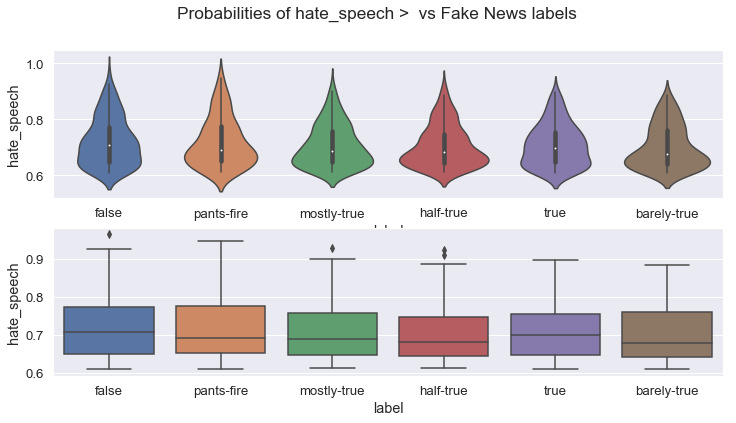

In [1384]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(12, 6))
axx=ax.flat

cat= 'hate_speech'

_df = df.sort_values('hate_speech', ascending = False).head(1000) 

sns.violinplot(y=cat,x= 'label' , data= _df, kind="box", ax=axx[0])
sns.catplot(y=cat,x= 'label' , data=_df, kind="box", ax=axx[1])
sns.set(font_scale=1.2)
fig.suptitle('Probabilities of '+cat+' > '+ ' vs Fake News labels')

plt.close(2);

In [1385]:
for i in df.sort_values('hate_speech', ascending = False).head(20).index:
    print(df.loc[i,'statement'])
    print('LABEL: ',df.loc[i,'label'],'\n\n')

The conviction rate is almost exactly the same for whites and blacks who commit murder.
LABEL:  false 


Says thousands at a Manhattan rally for Donald Trump were chanting We hate Muslims, we hate blacks, we want our great country back.
LABEL:  pants-fire 


Obama regime planned the influx of illegal alien children at the border.
LABEL:  pants-fire 


For 21 countries in Sub-Saharan Africa, we simply do not have data to say anything about trends in poverty.
LABEL:  mostly-true 


There are more atheists in the country right now than Jews, Muslims, Hindus and Buddhists combined and doubled.
LABEL:  false 


Our veterans, in many cases, are being treated worse than illegal immigrants.
LABEL:  false 


Says North Carolina Rep. Renee Ellmers was the only Republican to vote against an amendment to prioritize the deportation of sexual criminals who are illegal immigrants.
LABEL:  half-true 


The wealth gap between blacks and whites in the United States is greater than the black-white wealth

In [1386]:
for i in df.sort_values('hate_speech', ascending = True).head(10).index:
    print(df.loc[i,'statement'])
    print('LABEL: ',df.loc[i,'label'],'\n\n')

You cant check out a library book without a photo ID.
LABEL:  barely-true 


Our tax code is . . . 80,000 pages.
LABEL:  false 


The Internal Revenue Service spent $60,000 on a Star Trek training video.
LABEL:  half-true 


Says the State Department spent $630,000 to get 2 million Facebook Likes.
LABEL:  true 


The $5 billion website for Obamacare never worked. Still doesnt work.
LABEL:  false 


28 percent of Kentuckians dont have any online access.
LABEL:  half-true 


Most Americans are now getting their news from Facebook.
LABEL:  false 


Says she is the subject of 60 books.
LABEL:  true 


Americas tax code hasnt been updated in 30 years.
LABEL:  barely-true 


He admits he still doesn't know how to use a computer, can't send an e-mail.
LABEL:  mostly-true 




In [1387]:
df.sort_values('hate_speech', ascending = False).head(500).groupby(['label']).mean()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,hate_speech
label,,,,,,
barely-true,10.378378,10.581081,10.702703,10.243243,4.540541,0.776653
false,13.188034,19.230769,14.444444,13.153846,10.589744,0.777862
half-true,10.644444,12.055556,15.522222,13.266667,4.888889,0.774031
mostly-true,12.373626,13.208791,20.120879,21.505495,4.593407,0.769891
pants-fire,15.519231,25.057692,17.019231,14.500000,22.942308,0.786693
true,11.263158,10.447368,19.078947,18.250000,2.973684,0.764177


In [1388]:
df.sort_values('hate_speech', ascending = False).head(2000).groupby(['label']).std()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,hate_speech
label,,,,,,
barely-true,18.148503,24.196305,32.625985,32.913442,13.747127,0.095380
false,20.820055,31.194341,32.219018,31.810636,21.884502,0.108705
half-true,20.419691,24.645754,39.778650,40.330088,11.449138,0.094522
mostly-true,21.219826,23.262100,44.326093,45.081844,10.109474,0.096768
pants-fire,18.931169,31.932914,25.131542,23.618606,31.607767,0.109144
true,19.476311,19.770130,40.795476,41.757016,8.912659,0.098947
